In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from statistics import mean 

In [3]:
import datetime as dt
from dateutil.relativedelta import *

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ffd364917d0>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [14]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ffd364aea10>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [15]:
engine.execute("select * from measurement limit 10").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [17]:
pd.read_sql("select * from measurement", engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [ ]:
# Design a query to retrieve the last 12 months 
# of precipitation data and plot the results

In [20]:
# Calculate the date 1 year ago from the last data point in the database
first_date = (session.query(measurement.date)
              .order_by(measurement.date.desc()).first())

query_date =first_date[0].split("-")

for i in range(0, len(query_date)): 
    query_date[i] = int(query_date[i])

query_date=(dt.date(query_date[0],query_date[1],query_date[2]))

query_date = query_date+relativedelta(months=-12)
print(query_date)
print(first_date[0])

2016-08-23
2017-08-23


In [21]:
# Perform a query to retrieve the data and precipitation scores
query= session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).all()

In [22]:
# Save the query results as a Pandas DataFrame and 
# set the index to the date column
rain_df = pd.DataFrame(query).set_index('date') 

In [26]:
# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date')
# rain_df

In [29]:
rain_df=rain_df.dropna()

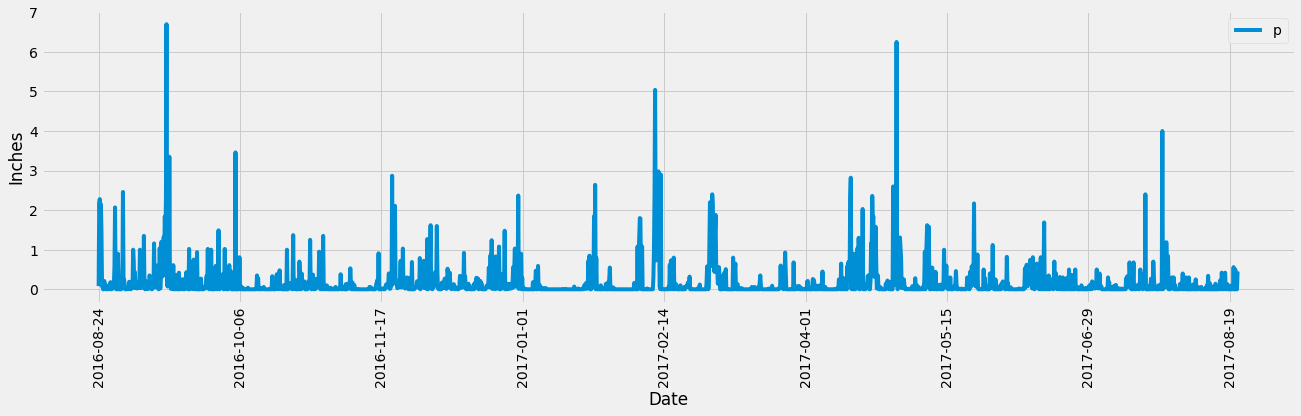

In [56]:
# Use Pandas Plotting with Matplotlib to plot the data
# Pandas
rain_df.plot(kind='line', rot = 90, figsize = (20,5))
plt.xlabel('Date')
plt.ylabel("Inches")
plt.legend(loc="best", labels ="precipitation")
plt.show()

In [31]:
# Use Pandas to calcualte the summary statistics for the 
# precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
query_stations= session.query(measurement.station).distinct().all()
query_stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [33]:
# What are the most active stations? 
# (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(measurement.station,
    func.count(measurement.id).label('qty')
    ).group_by(measurement.station
    ).order_by(desc('qty')).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, 
# calculate the lowest temperature recorded, 
# highest temperature recorded, and average 
# temperature of the most active station?
high_temp= session.query(func.max(measurement.tobs).\
    filter(measurement.station == active_stations[0][0])).all()
low_temp= session.query(func.min(measurement.tobs).\
    filter(measurement.station == active_stations[0][0])).all()
mean_temp= session.query(func.avg(measurement.tobs).\
    filter(measurement.station == active_stations[0][0])).all()

In [35]:
temperatures_df  = pd.DataFrame({
    "Most Active Station": active_stations[0][0],
    "Lowest Temperature" : low_temp[0],
    "Highest Temperature": high_temp[0],
    "Average Temperature": round(mean_temp[0][0],2)
})
temperatures_df

,Most Active Station,Lowest Temperature,Highest Temperature,Average Temperature
0,USC00519281,54.0,85.0,71.66


In [36]:
# Choose the station with the highest number of temperature observations.
active_stations_temp=session.query(measurement.station,
    func.count(measurement.tobs).label('qty')
    ).group_by(measurement.station
    ).order_by(desc('qty')).all()

In [37]:
# Query the last 12 months of tobs data for this station
active_temp = session.query(measurement.tobs).\
    filter(measurement.date > query_date).\
    filter(measurement.station == active_stations_temp[0][0]).all()

flat_list = []
for sublist in active_temp:
    for item in sublist:
        flat_list.append(item)
active_temp = flat_list

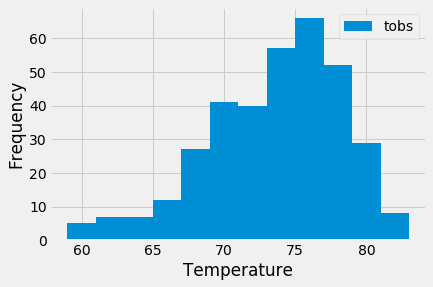

In [38]:
# Plot the results as a histogram
plt.hist(active_temp, bins = 12, label= 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc= 'best')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
